# Task 1.2: Semantic Feature Extraction

In [435]:
import pandas as pd
import matplotlib.pyplot as plt

## Loading the new dataset

In [436]:
df = pd.read_csv('../dataset/new_customer_supermarket.csv', sep='\t', index_col=0)
df

,BasketID,BasketDate,Sale,CustomerID,ProdID,ProdDescr,Qta,TotSale
0,539993,2011-04-01 10:00:00,1.95,13313.0,22386,JUMBO BAG PINK POLKADOT,10,19.5
1,539993,2011-04-01 10:00:00,0.42,13313.0,21499,BLUE POLKADOT WRAP,25,10.5
2,539993,2011-04-01 10:00:00,0.42,13313.0,21498,RED RETROSPOT WRAP,25,10.5
3,539993,2011-04-01 10:00:00,2.10,13313.0,22379,RECYCLING BAG RETROSPOT,5,10.5
4,539993,2011-04-01 10:00:00,1.25,13313.0,20718,RED RETROSPOT SHOPPER BAG,10,12.5
...,...,...,...,...,...,...,...,...
280142,581585,2011-09-12 12:31:00,0.95,15804.0,23145,ZINC TLIGHT HOLDER STAR LARGE,12,11.4
280143,581585,2011-09-12 12:31:00,1.95,15804.0,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,23.4
280144,581586,2011-09-12 12:49:00,2.95,13113.0,22061,LARGE CAKE STAND HANGING STRAWBERY,8,23.6
280145,581586,2011-09-12 12:49:00,1.25,13113.0,23275,SET OF HANGING OWLS OLLIE BEAK,24,30.0


In [437]:
df.dtypes

BasketID        int64
BasketDate     object
Sale          float64
CustomerID    float64
ProdID         object
ProdDescr      object
Qta             int64
TotSale       float64
dtype: object

In [438]:
df = df.astype({'BasketDate': 'datetime64',
                'BasketID': 'object',
                'CustomerID': 'object'})

## Feature Extraction

In [439]:
products = pd.DataFrame(df['ProdDescr'].unique()).rename(columns={0: 'ProdDescr'})
products

,ProdDescr
0,JUMBO BAG PINK POLKADOT
1,BLUE POLKADOT WRAP
2,RED RETROSPOT WRAP
3,RECYCLING BAG RETROSPOT
4,RED RETROSPOT SHOPPER BAG
...,...
3382,CLASSICAL ROSE TABLE LAMP
3383,PINK CRYSTAL SKULL PHONE CHARM
3384,PINK JEWELLED MIRROR TRINKET TRAY
3385,CREAM HANGING HEART TLIGHT HOLDER


In [440]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [441]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def lemmatize_descr(descr):
    # print(pos_tag(word_tokenize(descr.lower())))
    tokenized_descr = [token for token, pos in pos_tag(word_tokenize(descr.lower()))
                       if not token in stop_words and len(token) >= 3]
    return ' '.join(lemmatizer.lemmatize(token) for token in tokenized_descr)

In [442]:
products['ProdDescr'] = products['ProdDescr'].apply(lemmatize_descr)
products

,ProdDescr
0,jumbo bag pink polkadot
1,blue polkadot wrap
2,red retrospot wrap
3,recycling bag retrospot
4,red retrospot shopper bag
...,...
3382,classical rose table lamp
3383,pink crystal skull phone charm
3384,pink jewelled mirror trinket tray
3385,cream hanging heart tlight holder


In [443]:
products.drop_duplicates(ignore_index=True, inplace=True)
products

,ProdDescr
0,jumbo bag pink polkadot
1,blue polkadot wrap
2,red retrospot wrap
3,recycling bag retrospot
4,red retrospot shopper bag
...,...
3342,classical rose table lamp
3343,pink crystal skull phone charm
3344,pink jewelled mirror trinket tray
3345,cream hanging heart tlight holder


In [444]:
from collections import Counter

In [445]:
keywords_counter = Counter(word for descr in products['ProdDescr'] for word in descr.split())
print("Nb of keywords in '{}': {}".format('ProdDescr', len(keywords_counter)))

Nb of keywords in 'ProdDescr': 1684


In [446]:
keywords_counter = sorted(keywords_counter.items(), key=lambda x: x[1], reverse=True)

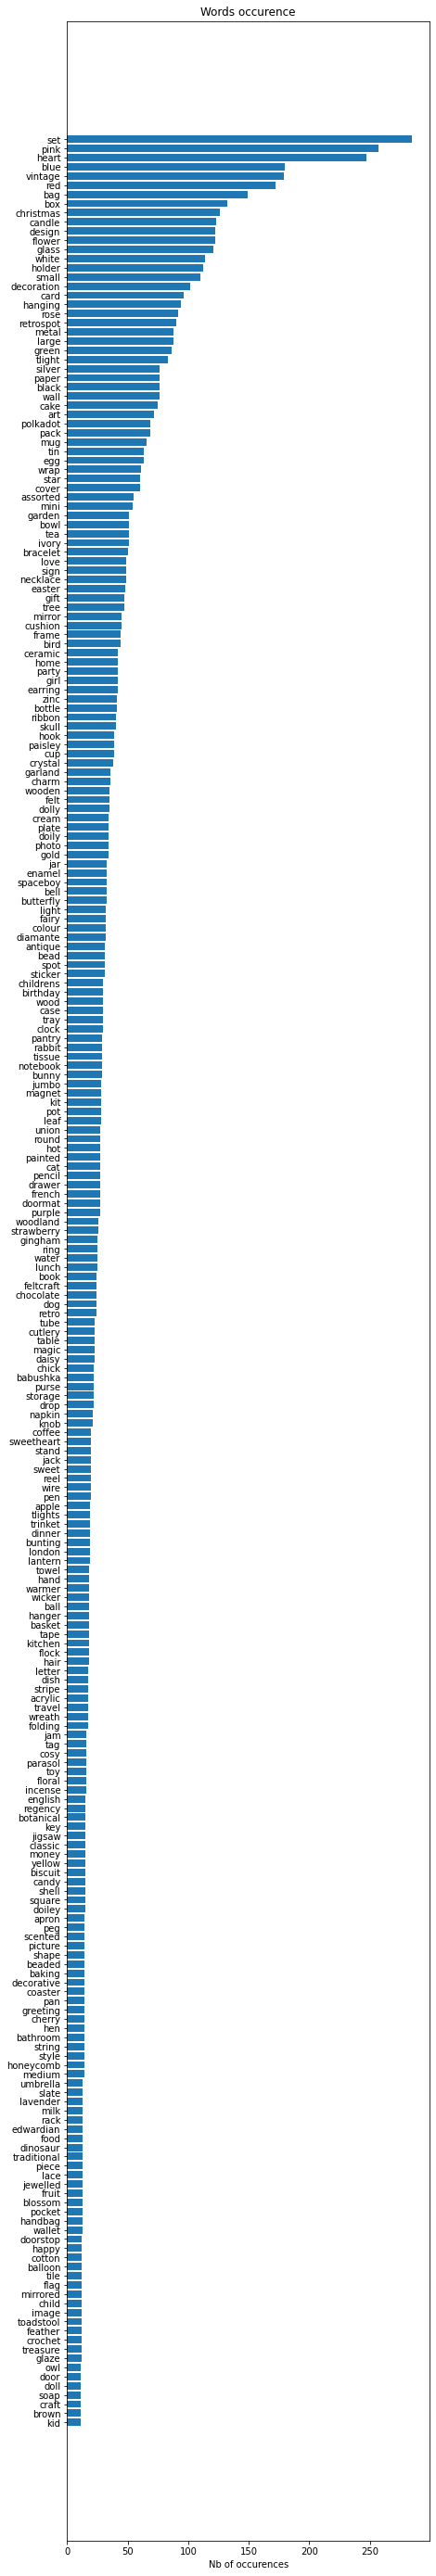

In [447]:
fig, ax = plt.subplots(figsize=(7,50))
y_axis = [i[1] for i in keywords_counter[:250]]
x_axis = [k for k, i in enumerate(keywords_counter[:250])]
x_label = [i[0] for i in keywords_counter[:250]]
plt.yticks(x_axis, x_label)
plt.xlabel('Nb of occurences')
ax.barh(x_axis, y_axis, align='center')
ax = plt.gca()
ax.invert_yaxis()
plt.title('Words occurence')
plt.show()

In [448]:
from gensim.models import Word2Vec

In [449]:
model = Word2Vec([[word for word in descr.split()] 
                  for descr in products['ProdDescr']], min_count=1)

In [450]:
embeddings = model.wv[model.wv.vocab]

## Normalization \& Dimensionality Reduction

Euclidian similarity cannot work well for the high-dimensional word embeddings. This is because Euclidian similarity will increase as the number of dimensions increases, even if the word embedding stands for different meanings. Alternatively, we can use cosine similarity to measure the similarity between two vectors. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. The cosine similarity captures the angle of the word vectors and not the magnitude. Under cosine similarity, no similarity is expressed as a 90-degree angle while the total similarity of 1 is at a 0-degree angle.

Scaling inputs to unit norms is a common operation for text classification or clustering for instance. For instance the dot product of two l2-normalized TF-IDF vectors is the cosine similarity of the vectors and is the base similarity metric for the Vector Space Model commonly used by the Information Retrieval community.

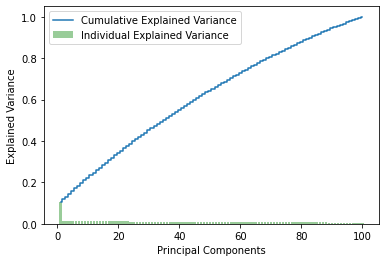

In [452]:
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

scaler = Normalizer()
scaled_embeddings = scaler.fit_transform(embeddings)

pca = PCA()
pca.fit(scaled_embeddings)

plt.step(range(1, embeddings.shape[1] + 1), pca.explained_variance_ratio_.cumsum(), 
         where='mid', label='Cumulative Explained Variance')
plt.bar(range(1, embeddings.shape[1] + 1), pca.explained_variance_ratio_, 
        alpha=0.4, color='g', label='Individual Explained Variance')

plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.legend(loc='upper left');

In [453]:
pca = PCA(n_components=70)
pca_embeddings = pca.fit_transform(scaled_embeddings)

## Clustering

In [454]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [455]:
elbow = []
silhouette = []
for k in range(2, 10):
    kmeans = KMeans(init='k-means++', n_clusters=k)
    clusters = kmeans.fit_predict(pca_embeddings)
    elbow.append(kmeans.inertia_)
    silhouette.append(silhouette_score(pca_embeddings, clusters))

In [456]:
print('The best silhouette score is:', max(silhouette))

The best silhouette score is: 0.07373862


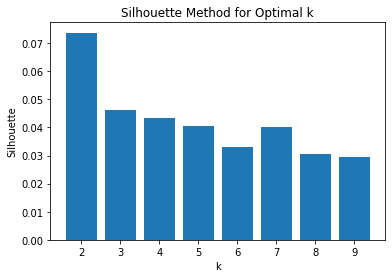

In [457]:
plt.bar(range(2, 10), silhouette)
plt.title('Silhouette Method for Optimal k')
plt.ylabel('Silhouette')
plt.xlabel('k');

In [458]:
kmeans = KMeans(init='k-means++', n_clusters=2)
clusters_embeddings = kmeans.fit_predict(pca_embeddings)

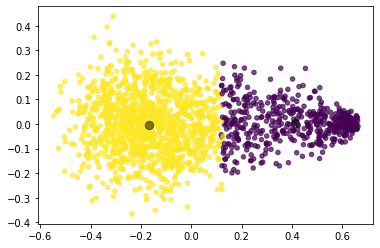

In [459]:
# create a scatter plot
plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], c=clusters_embeddings, s=20, alpha=0.7)
# select cluster centers
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);

In [460]:
pd.DataFrame(pd.Series(clusters_embeddings).value_counts(), columns=['ProductsNb']).T

,1,0
ProductsNb,1191,493


For comparison, if we run only the K-Means algorithm without the PCA step, the result would be the following:

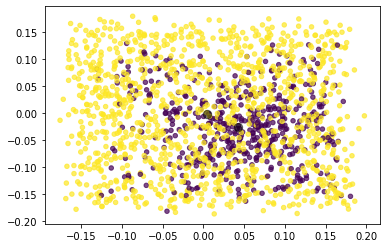

In [461]:
# create a scatter plot
plt.scatter(scaled_embeddings[:, 0], scaled_embeddings[:, 1], c=clusters_embeddings, s=20, alpha=0.7)
# select cluster centers
centroids = pca.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);

### Elbow method

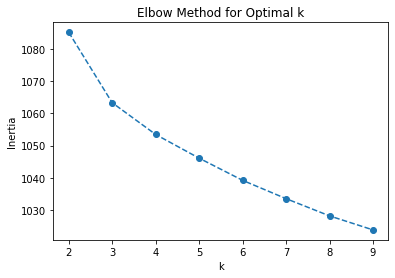

In [462]:
plt.plot(range(2, 10), elbow, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.ylabel('Inertia')
plt.xlabel('k');

In [463]:
print('The silhouette score for k = 3 is:', silhouette[1])

The silhouette score for k = 3 is: 0.046301767


In [464]:
kmeans = KMeans(init='k-means++', n_clusters=3)
clusters_embeddings = kmeans.fit_predict(pca_embeddings)

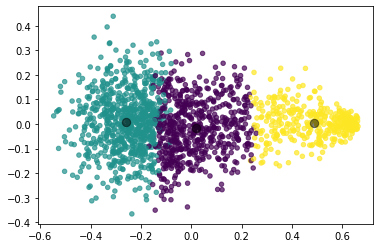

In [465]:
# create a scatter plot
plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], c=clusters_embeddings, s=20, alpha=0.7)
# select cluster centers
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);

In [466]:
pd.DataFrame(pd.Series(clusters_embeddings).value_counts(), columns=['ProductsNb']).T

,1,0,2
ProductsNb,732,583,369


For comparison, if we run only the K-Means algorithm without the PCA step, the result would be the following:

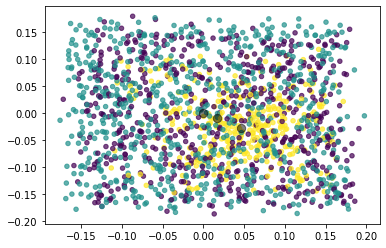

In [467]:
# create a scatter plot
plt.scatter(scaled_embeddings[:, 0], scaled_embeddings[:, 1], c=clusters_embeddings, s=20, alpha=0.7)
# select cluster centers
centroids = pca.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);

In [ ]:
from SemanticCloud.keywords import keywordExtractor
from SemanticCloud.wordembeddings import word2vec
from SemanticCloud.reduction import Mapper
from SemanticCloud.viz import createViz
import pandas as pd
import numpy as np

text = # Big old text document

# Get keywords, embeddings and map to 2D
keywords = keywordExtractor(text)
embeddings = word2vec(keywords)
data = Mapper(embeddings)

# Putting the data together and removing outliers
df = pd.merge(data, pd.DataFrame.from_dict(keywords, columns=['value'], orient='index'), left_index=True, right_index=True)
df = df[np.abs(df.X - df.X.mean()) <= (2 * df.X.std())]
df = df[np.abs(df.Y - df.Y.mean()) <= (2 * df.Y.std())]

# Create Visualisation
createViz(df,folder=folder)